# Pipeline Modelling

In [11]:
import pandas as pd
import numpy as np

In [12]:
diabetes = pd.read_csv('cleaned_diabetes.csv')
diabetes = diabetes.drop(columns={'Unnamed: 0'})
diabetes.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,repaglinide,...,change_yes,change_no,diabetesMed_yes,diabetesMed_no,age_encoding,glu_serum_encoding,A1C_encoded,total_visits,polypharmacy,num_meds_chanaged
0,1,41,0,1,0,0,0,1,No,No,...,0,1,0,1,0,0,0,0,0,0
1,3,59,0,18,0,0,0,9,No,No,...,1,0,1,0,1,0,0,0,1,1
2,2,11,5,13,2,0,1,6,No,No,...,0,1,1,0,2,0,0,3,1,0
3,2,44,1,16,0,0,0,7,No,No,...,1,0,1,0,3,0,0,0,1,1
4,1,51,0,8,0,0,0,5,No,No,...,1,0,1,0,4,0,0,0,1,0


In [13]:
X = diabetes.drop(columns=['readmitted'])
y = diabetes['readmitted'] # what we're predicting

In [14]:
diabetes['readmitted'].value_counts(normalize=True)

readmitted
0    0.888424
1    0.111576
Name: proportion, dtype: float64

Since only 11.16% of the data is labelled as readmitted within 30 days, this is a **class imbalance**. We will need to account for it to avoid the mostly being biased and select the majority class, No or > 30, every time. 

In [15]:
diabetes['tolazamide'].unique()

array(['No', 'Steady', 'Up'], dtype=object)

In [16]:
# 80% train, 10% validation, 10% test
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [17]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

In [18]:
# We also need to encode the medication! 
meds = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone'
]

med_encoding = {'No':0,'Down':1,'Steady':2,'Up':3}
for col in meds:
    if col in X_train.columns:
        X_train[col] = X_train[col].map(med_encoding)
        X_val[col] = X_val[col].map(med_encoding)
        X_test[col] = X_test[col].map(med_encoding)
        X[col] = X[col].map(med_encoding)


In [19]:
meds = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone'
]
for col in meds:
    print(X_train[col].unique())

[0 2 1 3]
[0 2 3 1]
[0 2 3 1]
[0 2 3]
[0 2 3 1]
[0 2]
[0 2 3 1]
[0 2 3 1]
[0 2]
[1 0 2 3]
[0 1 2 3]
[0 2 3 1]
[0 2 1 3]
[0]
[0 2 3]
[0 1 2 3]
[0 2 3 1]
[0 2]
[0]


## Logistic Regression Model

In [20]:
# Logistic Regression Model
num_cols = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses', 'age_encoding',
    'glu_serum_encoding', 'A1C_encoded', 'total_visits'
]

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [21]:
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [22]:
# Predict on validation set
y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:, 1]

print("Validation Set Evaluation:")
print(classification_report(y_val, y_val_pred))
print("ROC AUC:", roc_auc_score(y_val, y_val_prob))


Validation Set Evaluation:
              precision    recall  f1-score   support

           0       0.92      0.69      0.79      9039
           1       0.18      0.55      0.27      1135

    accuracy                           0.67     10174
   macro avg       0.55      0.62      0.53     10174
weighted avg       0.84      0.67      0.73     10174

ROC AUC: 0.674763153110871


In [29]:
# 1. Different regularization
model = LogisticRegression(
    C=0.1,  # Try different values: 0.01, 0.1, 1, 10
    penalty='l1',  # Try 'l1' for feature selection
    solver='liblinear',
    class_weight='balanced',
    max_iter=2000,
    random_state=42
)

# 2. Add simple interaction features
X_train['high_risk_combo'] = (X_train['age_encoding'] * X_train['number_emergency'])
X_train['care_intensity'] = (X_train['num_medications'] * X_train['time_in_hospital'])
X_val['high_risk_combo'] = (X_val['age_encoding'] * X_val['number_emergency'])
X_val['care_intensity'] = (X_val['num_medications'] * X_val['time_in_hospital'])

model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:, 1]

print("Validation Set Evaluation:")
print(classification_report(y_val, y_val_pred))
print("ROC AUC:", roc_auc_score(y_val, y_val_prob))


Validation Set Evaluation:
              precision    recall  f1-score   support

           0       0.92      0.69      0.79      9039
           1       0.18      0.55      0.27      1135

    accuracy                           0.67     10174
   macro avg       0.55      0.62      0.53     10174
weighted avg       0.84      0.67      0.73     10174

ROC AUC: 0.675197199799401


## Random Forest Model

In [13]:
# improve with random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced', 
    random_state=42
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [14]:
# Predict on validation set
y_val_pred_rf = rf_model.predict(X_val)
y_val_prob_rf = rf_model.predict_proba(X_val)[:, 1]

print("Validation Set Evaluation:")
print(classification_report(y_val, y_val_pred_rf))
print("ROC AUC:", roc_auc_score(y_val, y_val_prob_rf))


Validation Set Evaluation:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      9039
           1       0.57      0.01      0.02      1135

    accuracy                           0.89     10174
   macro avg       0.73      0.50      0.48     10174
weighted avg       0.85      0.89      0.84     10174

ROC AUC: 0.6530299197847019


In [15]:
y_val_pred_lr = model.predict(X_val)

print("Logistic Regression Accuracy:", accuracy_score(y_val, y_val_pred_lr))
print("Random Forest Accuracy:", accuracy_score(y_val, y_val_pred_rf))


Logistic Regression Accuracy: 0.6723019461372125
Random Forest Accuracy: 0.8887359937094554


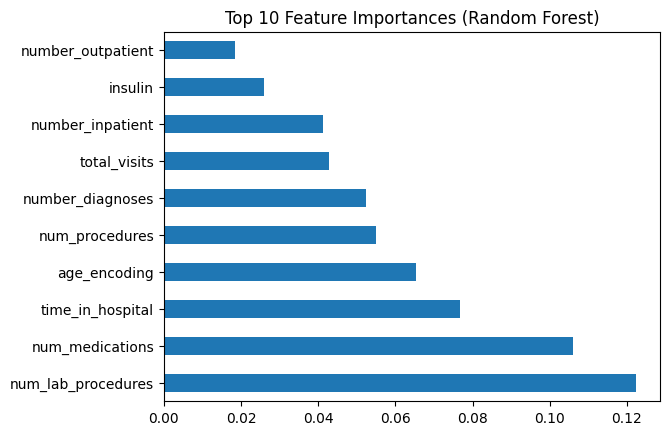

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()


## XGBoost Model


In [18]:
from xgboost import XGBClassifier

In [47]:
xgb_model = XGBClassifier(
    n_estimators = 100,
    max_depth = 5,
    learning_rate = 0.1,
    scale_pos_weight = 1,
    use_label_encoder = False,
    eval_metric = 'logloss',
    random_state = 42
)

In [48]:
xgb_model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:17:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [49]:
from sklearn.metrics import accuracy_score, classification_report

y_val_pred_xgb = xgb_model.predict(X_val)

print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_xgb))
print("Classification Report:\n", classification_report(y_val, y_val_pred_xgb))


XGBoost Validation Accuracy: 0.8884411244348339
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      9039
           1       0.50      0.00      0.01      1135

    accuracy                           0.89     10174
   macro avg       0.69      0.50      0.47     10174
weighted avg       0.85      0.89      0.84     10174



* Overall accuracy is ~88.9%, but this is dominated by the majority class (negatives) --> underestimating minority class

* The model is almost never correctly identifying the positive class (readmissions).

* This is confirmed by recall = 0.00 for class 1, meaning it missed almost all actual positives.

* Macro average recall and F1 are low due to poor positive class detection.

* This is a classic problem with imbalanced datasets — accuracy alone is misleading.

## Light GBM

In [35]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)

In [36]:
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9082, number of negative: 72311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 81393, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', random_state=42)

In [37]:
y_val_pred_lgb = lgb_model.predict(X_val)

In [38]:
print("LGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_lgb))
print("Classification Report:\n", classification_report(y_val, y_val_pred_lgb))

LGBoost Validation Accuracy: 0.6590328287792412
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.67      0.78      9039
           1       0.19      0.61      0.28      1135

    accuracy                           0.66     10174
   macro avg       0.56      0.64      0.53     10174
weighted avg       0.85      0.66      0.72     10174



## Fine-tune with Hyperparameters

In [58]:
# we will use the XGBoost Model
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'max_depth': [3,5,7,9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5, 7]
}

random_search = RandomizedSearchCV(
    estimator = XGBClassifier(
        n_estimators = 100,
        max_depth = 5,
        learning_rate = 0.1,
        scale_pos_weight = 1,
        eval_metric = 'logloss',
        random_state = 42
        ),
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
print("Best parameters:", random_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=300, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=300, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=300, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=7, n_estimators=400, subsample=0.8; total t

In [ ]:
# scale scale_pos_weight to pay more attention to the minority class 
xgb_model = XGBClassifier(
    subsample= 0.8,
    n_estimators = 400,
    min_child_weight = 5,
    max_depth = 7,
    learning_rate = 0.01,
    colsample_bytree = 0.6,
    scale_pos_weight = np.sum(y_train==0) / np.sum(y_train==1),
    use_label_encoder = False,
    eval_metric = 'logloss',
    random_state = 42
)

In [66]:
xgb_model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:38:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)

In [67]:
y_val_pred_xgb = xgb_model.predict(X_val)

print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_xgb))
print("Classification Report:\n", classification_report(y_val, y_val_pred_xgb))

XGBoost Validation Accuracy: 0.657951641438962
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.67      0.78      9039
           1       0.18      0.59      0.28      1135

    accuracy                           0.66     10174
   macro avg       0.55      0.63      0.53     10174
weighted avg       0.84      0.66      0.72     10174



In [69]:
for spw in [1, 2, 3, 5]:
    xgb_model = XGBClassifier(
        subsample= 0.8,
        n_estimators = 400,
        min_child_weight = 5,
        max_depth = 7,
        learning_rate = 0.01,
        colsample_bytree = 0.6,
        scale_pos_weight = np.sum(y_train==0) / np.sum(y_train==1),
        use_label_encoder = False,
        eval_metric = 'logloss',
        random_state = 42
    )
    xgb_model.fit(X_train, y_train)
    preds = xgb_model.predict(X_val)
    print(f"scale_pos_weight: {spw}")
    print(classification_report(y_val, preds))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:39:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


scale_pos_weight: 1
              precision    recall  f1-score   support

           0       0.93      0.67      0.78      9039
           1       0.18      0.59      0.28      1135

    accuracy                           0.66     10174
   macro avg       0.55      0.63      0.53     10174
weighted avg       0.84      0.66      0.72     10174



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:39:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


scale_pos_weight: 2
              precision    recall  f1-score   support

           0       0.93      0.67      0.78      9039
           1       0.18      0.59      0.28      1135

    accuracy                           0.66     10174
   macro avg       0.55      0.63      0.53     10174
weighted avg       0.84      0.66      0.72     10174



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:39:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


scale_pos_weight: 3
              precision    recall  f1-score   support

           0       0.93      0.67      0.78      9039
           1       0.18      0.59      0.28      1135

    accuracy                           0.66     10174
   macro avg       0.55      0.63      0.53     10174
weighted avg       0.84      0.66      0.72     10174



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:39:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


scale_pos_weight: 5
              precision    recall  f1-score   support

           0       0.93      0.67      0.78      9039
           1       0.18      0.59      0.28      1135

    accuracy                           0.66     10174
   macro avg       0.55      0.63      0.53     10174
weighted avg       0.84      0.66      0.72     10174



In [70]:
from sklearn.metrics import classification_report

y_proba = xgb_model.predict_proba(X_val)[:, 1]

for thresh in [0.3, 0.4, 0.5]:
    y_pred = (y_proba >= thresh).astype(int)
    print(f"\nThreshold: {thresh}")
    print(classification_report(y_val, y_pred))



Threshold: 0.3
              precision    recall  f1-score   support

           0       0.96      0.11      0.19      9039
           1       0.12      0.97      0.21      1135

    accuracy                           0.20     10174
   macro avg       0.54      0.54      0.20     10174
weighted avg       0.87      0.20      0.19     10174


Threshold: 0.4
              precision    recall  f1-score   support

           0       0.95      0.38      0.54      9039
           1       0.14      0.83      0.24      1135

    accuracy                           0.43     10174
   macro avg       0.54      0.60      0.39     10174
weighted avg       0.86      0.43      0.51     10174


Threshold: 0.5
              precision    recall  f1-score   support

           0       0.93      0.67      0.78      9039
           1       0.18      0.59      0.28      1135

    accuracy                           0.66     10174
   macro avg       0.55      0.63      0.53     10174
weighted avg       0.84   

In [71]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [5, 6, 7],
    'min_child_weight': [1, 3, 5],
    'scale_pos_weight': [2, 3, 5],
    'learning_rate': [0.01, 0.05],
}

grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
                    param_grid, 
                    scoring='f1',
                    cv=3,
                    verbose=1)

grid.fit(X_train, y_train)
print(grid.best_params_)


Fitting 3 folds for each of 54 candidates, totalling 162 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:35:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:35:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:35:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:35:12] WARN

{'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'scale_pos_weight': 5}


In [143]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'scale_pos_weight': [4, 5, 6, 7],
    'max_depth': [4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(
    XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        colsample_bytree=0.6,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ),
    param_grid,
    cv=3,
    scoring='f1',  # Optimize for F1-score
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best CV F1-score:", grid_search.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:42:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:42:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:42:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:42:26] WARN

Best parameters: {'max_depth': 4, 'min_child_weight': 3, 'scale_pos_weight': 7, 'subsample': 0.9}
Best CV F1-score: 0.27878902515928466


In [142]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

y_proba = xgb_model.predict_proba(X_val)[:, 1]

print("Threshold optimization:")
print("Thresh | Precision | Recall | F1-Score")
print("-" * 40)

best_f1 = 0
best_thresh = 0.44

for thresh in np.arange(0.35, 0.55, 0.01):
    y_pred = (y_proba >= thresh).astype(int)
    precision_1 = precision_score(y_val, y_pred)
    recall_1 = recall_score(y_val, y_pred)
    f1_1 = f1_score(y_val, y_pred)
    
    print(f"{thresh:.2f}   | {precision_1:.3f}     | {recall_1:.3f}  | {f1_1:.3f}")
    
    if f1_1 > best_f1:
        best_f1 = f1_1
        best_thresh = thresh

print(f"\nBest threshold: {best_thresh:.2f} with F1-score: {best_f1:.3f}")

Threshold optimization:
Thresh | Precision | Recall | F1-Score
----------------------------------------
0.35   | 0.133     | 0.878  | 0.232
0.36   | 0.136     | 0.865  | 0.235
0.37   | 0.138     | 0.846  | 0.238
0.38   | 0.140     | 0.828  | 0.240
0.39   | 0.143     | 0.807  | 0.243
0.40   | 0.145     | 0.788  | 0.245
0.41   | 0.148     | 0.765  | 0.248
0.42   | 0.152     | 0.747  | 0.253
0.43   | 0.155     | 0.727  | 0.256
0.44   | 0.158     | 0.704  | 0.258
0.45   | 0.160     | 0.675  | 0.259
0.46   | 0.164     | 0.655  | 0.262
0.47   | 0.167     | 0.633  | 0.265
0.48   | 0.171     | 0.614  | 0.268
0.49   | 0.177     | 0.598  | 0.273
0.50   | 0.180     | 0.573  | 0.274
0.51   | 0.186     | 0.555  | 0.279
0.52   | 0.191     | 0.532  | 0.281
0.53   | 0.197     | 0.508  | 0.284
0.54   | 0.202     | 0.480  | 0.284
0.55   | 0.207     | 0.454  | 0.285

Best threshold: 0.55 with F1-score: 0.285


Best threshold: 0.43, F1: 0.295


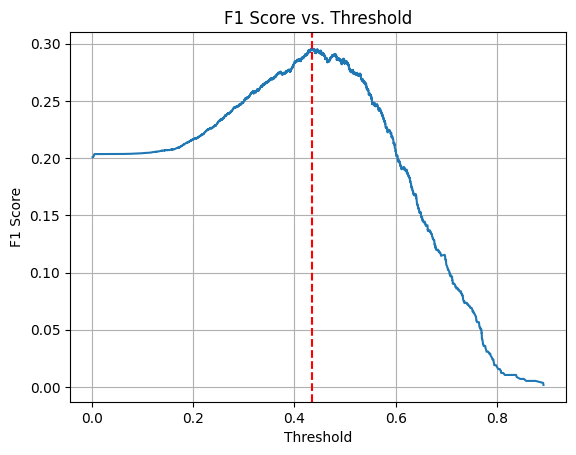

In [80]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

prec, rec, threshs = precision_recall_curve(y_val, y_proba)
f1 = 2 * prec * rec / (prec + rec + 1e-8)

best_idx = np.argmax(f1)
print(f"Best threshold: {threshs[best_idx]:.2f}, F1: {f1[best_idx]:.3f}")

plt.plot(threshs, f1[:-1])
plt.axvline(threshs[best_idx], color='r', linestyle='--')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold")
plt.grid(True)
plt.show()


In [83]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

param_dist = {
    'n_estimators': randint(100, 600),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.1),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.5, 0.5),
    'scale_pos_weight': [5],  # fixed or slightly varied if needed
}

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    scoring='f1',
    n_iter=50,
    cv=3,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
print("Best Params:", random_search.best_params_)



Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:46:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:46:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:46:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:46:22] WARN

Best Params: {'colsample_bytree': np.float64(0.8093574700581173), 'learning_rate': np.float64(0.037281761570859454), 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 527, 'scale_pos_weight': 5, 'subsample': np.float64(0.7956447755377811)}


In [185]:
xgb_model = XGBClassifier(
    subsample= 0.7956447755377811,
    n_estimators = 527,
    min_child_weight = 2,
    max_depth = 3,
    learning_rate = 0.037281761570859454,
    colsample_bytree = 0.8093574700581173,
    scale_pos_weight = 5,
    use_label_encoder = False,
    eval_metric = 'logloss',
    random_state = 42
)
xgb_model.fit(X_train, y_train)
y_val_pred_xgb = xgb_model.predict(X_val)

print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_xgb))

y_proba = xgb_model.predict_proba(X_val)[:, 1]
thresh = 0.2
y_pred = (y_proba >= thresh).astype(int)
print("Classification Report:\n", classification_report(y_val, y_pred))

XGBoost Validation Accuracy: 0.8122757875079857
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.08      0.15     18079
           1       0.12      0.98      0.21      2270

    accuracy                           0.18     20349
   macro avg       0.54      0.53      0.18     20349
weighted avg       0.88      0.18      0.16     20349



In [186]:
y_proba = xgb_model.predict_proba(X_test)[:, 1]
thresh = 0.2
y_pred = (y_proba >= thresh).astype(int)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      9040
           1       0.58      0.02      0.03      1135

    accuracy                           0.89     10175
   macro avg       0.73      0.51      0.49     10175
weighted avg       0.85      0.89      0.84     10175



In [187]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, y_proba)

# Find threshold that maximizes F1
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = f1_scores.argmax()
best_thresh = thresholds[best_idx]

print(f"Best threshold for F1: {best_thresh:.3f}")


ValueError: Found input variables with inconsistent numbers of samples: [20349, 10175]

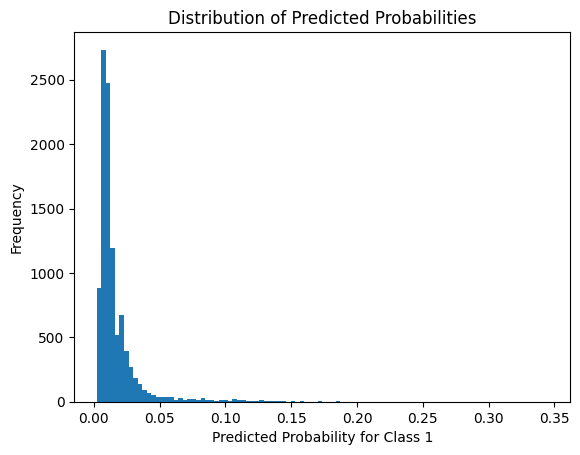

In [184]:
import matplotlib.pyplot as plt
plt.hist(y_proba, bins=100)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability for Class 1")
plt.ylabel("Frequency")
plt.show()


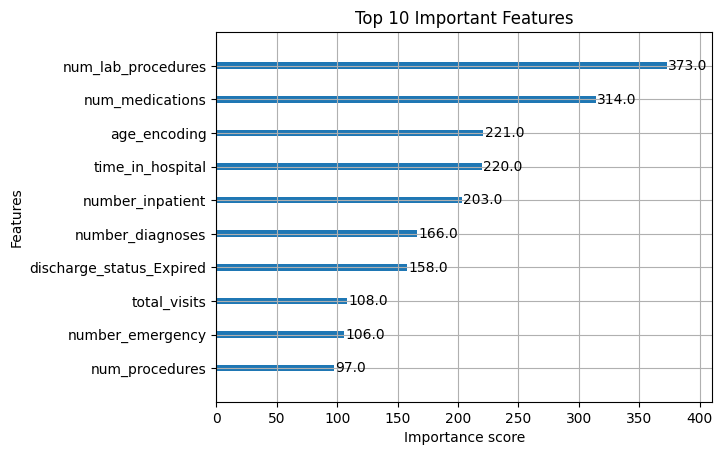

In [98]:
from xgboost import plot_importance

plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Important Features")
plt.show()




In [101]:
import numpy as np
from sklearn.metrics import f1_score

y_proba = xgb_model.predict_proba(X_val)[:, 1]
thresholds = np.arange(0.2, 0.7, 0.01)
scores = [f1_score(y_val, y_proba >= t) for t in thresholds]

best_thresh = thresholds[np.argmax(scores)]
print("Best threshold:", best_thresh)
print("Best F1-score for Class 1:", max(scores))


Best threshold: 0.4400000000000002
Best F1-score for Class 1: 0.29030470914127426


In [103]:

from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[7088 1951]
 [ 611  524]]


In [108]:
from imblearn.over_sampling import SMOTE

In [111]:
# Split data first
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# We also need to encode the medication! 
meds = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone'
]

med_encoding = {'No':0,'Down':1,'Steady':2,'Up':3}
for col in meds:
    if col in X_train.columns:
        X_train[col] = X_train[col].map(med_encoding)
        X_val[col] = X_val[col].map(med_encoding)
        X_test[col] = X_test[col].map(med_encoding)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [122]:
import xgboost as xgb
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_resampled, y_resampled)

# Predict and evaluate
y_proba = model.predict_proba(X_val)[:, 1]

thresh = 0.18
y_pred_adj = (y_proba > thresh).astype(int)
print(classification_report(y_val, y_pred_adj))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:20:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.91      0.78      0.84     18079
           1       0.19      0.41      0.26      2270

    accuracy                           0.74     20349
   macro avg       0.55      0.59      0.55     20349
weighted avg       0.83      0.74      0.78     20349



In [123]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_index = f1_scores.argmax()

print(f"Best threshold: {thresholds[best_index]:.2f}")
print(f"F1-score at best threshold: {f1_scores[best_index]:.2f}")



Best threshold: 0.18
F1-score at best threshold: 0.26


In [163]:
xgb_model = XGBClassifier(
    subsample= 0.8,
    n_estimators = 600,
    min_child_weight = 1,
    max_depth = 6,
    learning_rate = 0.03,
    colsample_bytree = 0.8,
    scale_pos_weight = 7.96,
    reg_alpha = 0.01,
    reg_lambda = 0.1,
    use_label_encoder = False,
    eval_metric = 'aucpr',
    random_state = 42,
    tree_method = 'hist',
    early_stopping_rounds = 50
)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
y_val_pred_xgb = xgb_model.predict(X_val)

print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_xgb))

y_proba = xgb_model.predict_proba(X_val)[:, 1]
thresh = 0.5199999999999998
y_pred = (y_proba >= thresh).astype(int)
print("Classification Report:\n", classification_report(y_val, y_pred))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [12:33:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


XGBoost Validation Accuracy: 0.6380657526168362
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.76      0.83     18079
           1       0.20      0.47      0.28      2270

    accuracy                           0.73     20349
   macro avg       0.56      0.62      0.56     20349
weighted avg       0.84      0.73      0.77     20349



In [162]:
def find_best_threshold_pr_curve(model, X_val, y_val, target_metric='f1'):
    """Find optimal threshold using precision-recall curve"""
    y_proba = model.predict_proba(X_val)[:, 1]
    
    if target_metric == 'f1':
        # Find threshold that maximizes F1 score
        thresholds = np.arange(0.1, 0.9, 0.01)
        f1_scores = []
        
        for threshold in thresholds:
            y_pred = (y_proba >= threshold).astype(int)
            f1 = f1_score(y_val, y_pred)
            f1_scores.append(f1)
        
        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx]
        best_f1 = f1_scores[best_idx]
        
        return best_threshold, best_f1
    
    elif target_metric == 'balanced':
        # Find threshold that balances precision and recall
        precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
        
        # Find threshold where precision ≈ recall
        diff = np.abs(precision - recall)
        best_idx = np.argmin(diff)
        best_threshold = thresholds[best_idx]
        
        return best_threshold, f1_score(y_val, (y_proba >= best_threshold).astype(int))
    
find_best_threshold_pr_curve(xgb_model, X_val, y_val)

(np.float64(0.5199999999999998), 0.28094173352623963)

=== THRESHOLD ANALYSIS ===


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Current Results (threshold = 0.52):
  Accuracy: 0.7313
  Class 1 Precision: 0.2003
  Class 1 Recall: 0.4705
  Class 1 F1: 0.2809

OPTIMAL THRESHOLD STRATEGIES:

MAX F1 WEIGHTED:
  Optimal Threshold: 0.620
  Accuracy: 0.8834
  Class 1 Precision: 0.3976
  Class 1 Recall: 0.0872
  Classification Report:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94     18079
     Class 1       0.40      0.09      0.14      2270

    accuracy                           0.88     20349
   macro avg       0.65      0.54      0.54     20349
weighted avg       0.84      0.88      0.85     20349


MAX ACCURACY:
  Optimal Threshold: 0.670
  Accuracy: 0.8893
  Class 1 Precision: 0.6164
  Class 1 Recall: 0.0198
  Classification Report:
              precision    recall  f1-score   support

     Class 0       0.89      1.00      0.94     18079
     Class 1       0.62      0.02      0.04      2270

    accuracy                           0.89     20349
   macro avg  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

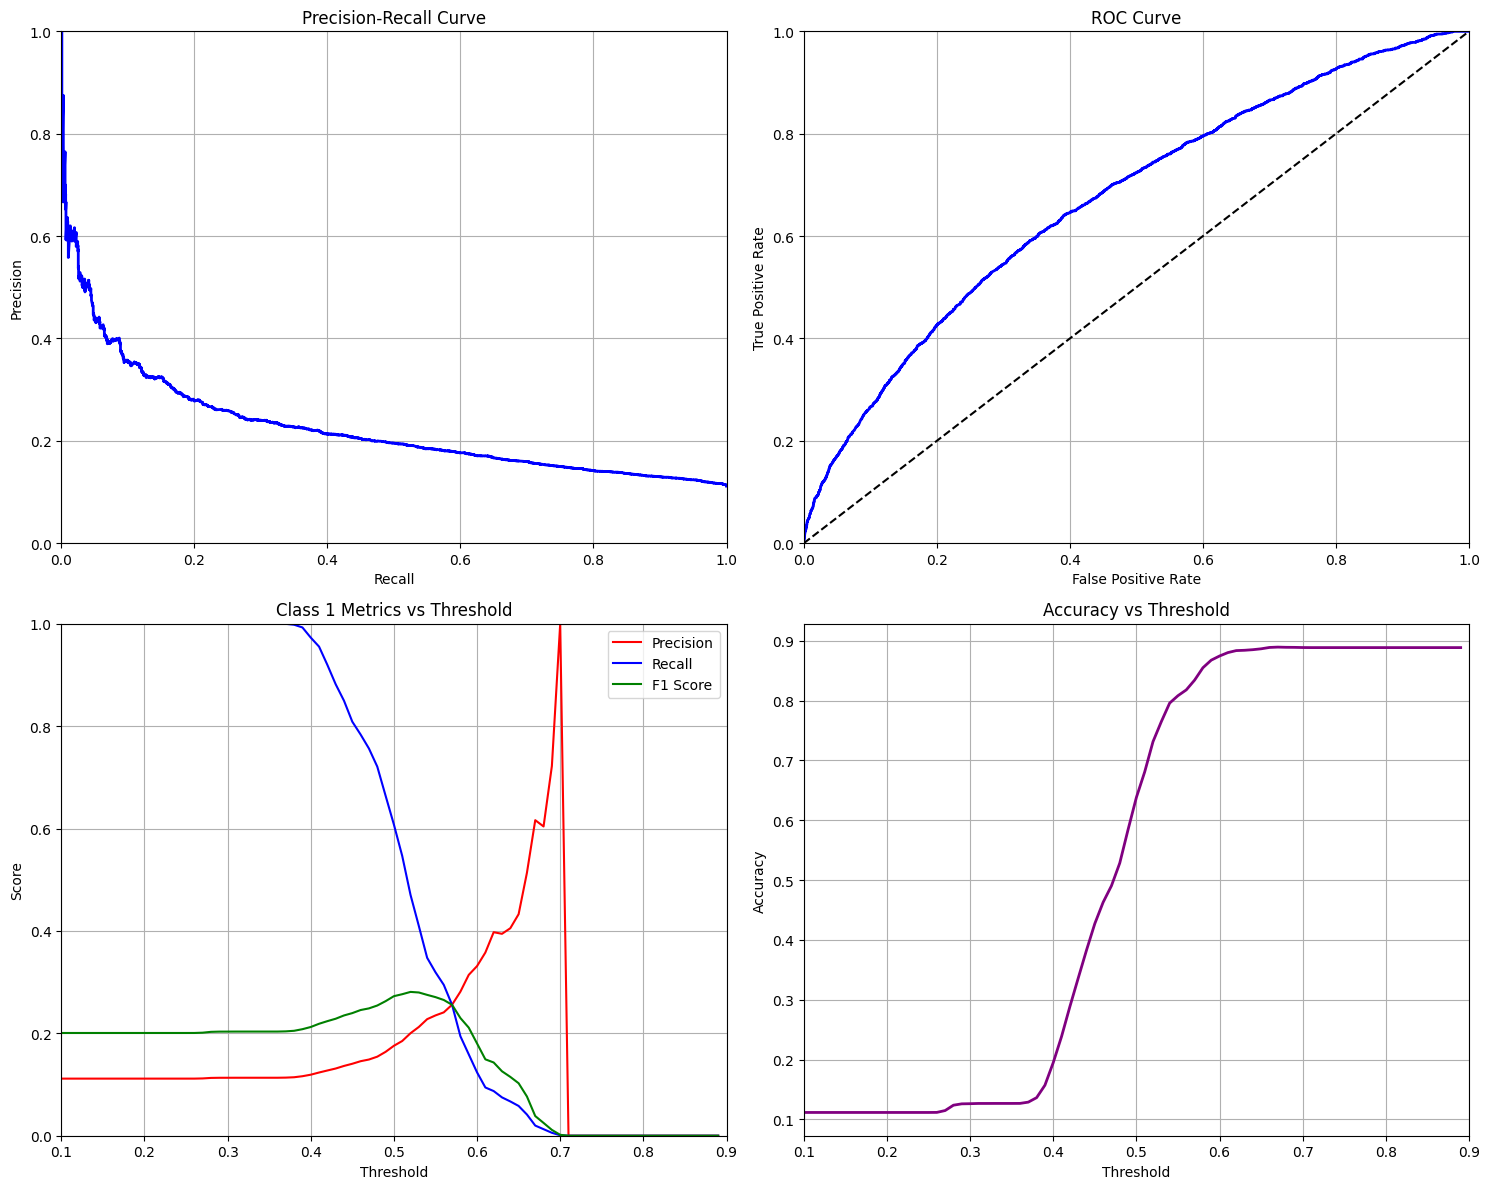


Key Metrics:
ROC AUC: 0.6710
PR AUC: 0.2258

=== RECOMMENDATIONS ===
Based on your results:
1. Your original threshold (0.52) gave better overall performance
2. The F1-optimized threshold improved recall but hurt precision significantly
3. Consider using different thresholds based on your business needs:
   - Conservative: Higher threshold for fewer false positives
   - Aggressive: Lower threshold to catch more positive cases
   - Balanced: Optimize for F1 score of minority class

4. Next steps: Try the resampling strategies (SMOTE, ADASYN) which should
   improve the model's ability to distinguish classes at any threshold


In [164]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, classification_report

def analyze_threshold_performance(model, X_val, y_val):
    """Comprehensive threshold analysis"""
    
    y_proba = model.predict_proba(X_val)[:, 1]
    
    # Test multiple thresholds
    thresholds = np.arange(0.1, 0.9, 0.01)
    
    results = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'precision_class1': [],
        'recall_class1': []
    }
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        
        results['threshold'].append(threshold)
        results['accuracy'].append(accuracy_score(y_val, y_pred))
        results['precision'].append(precision_score(y_val, y_pred, average='weighted'))
        results['recall'].append(recall_score(y_val, y_pred, average='weighted'))
        results['f1'].append(f1_score(y_val, y_pred, average='weighted'))
        
        # Class 1 (minority) specific metrics
        results['precision_class1'].append(precision_score(y_val, y_pred, pos_label=1))
        results['recall_class1'].append(recall_score(y_val, y_pred, pos_label=1))
    
    return results, y_proba

def find_optimal_thresholds(results):
    """Find optimal thresholds for different objectives"""
    
    results_array = {k: np.array(v) for k, v in results.items()}
    
    # Different optimization objectives
    objectives = {
        'max_f1_weighted': np.argmax(results_array['f1']),
        'max_accuracy': np.argmax(results_array['accuracy']),
        'balanced_precision_recall': np.argmin(np.abs(results_array['precision_class1'] - results_array['recall_class1'])),
        'max_f1_class1': np.argmax(2 * results_array['precision_class1'] * results_array['recall_class1'] / 
                                  (results_array['precision_class1'] + results_array['recall_class1'] + 1e-8))
    }
    
    optimal_thresholds = {}
    for objective, idx in objectives.items():
        optimal_thresholds[objective] = {
            'threshold': results_array['threshold'][idx],
            'accuracy': results_array['accuracy'][idx],
            'precision_class1': results_array['precision_class1'][idx],
            'recall_class1': results_array['recall_class1'][idx],
            'f1_weighted': results_array['f1'][idx]
        }
    
    return optimal_thresholds

def evaluate_threshold_strategies(model, X_val, y_val):
    """Evaluate different threshold strategies"""
    
    print("=== THRESHOLD ANALYSIS ===")
    
    # Get comprehensive results
    results, y_proba = analyze_threshold_performance(model, X_val, y_val)
    optimal_thresholds = find_optimal_thresholds(results)
    
    # Your current results for comparison
    print("Current Results (threshold = 0.52):")
    y_pred_current = (y_proba >= 0.52).astype(int)
    print(f"  Accuracy: {accuracy_score(y_val, y_pred_current):.4f}")
    print(f"  Class 1 Precision: {precision_score(y_val, y_pred_current, pos_label=1):.4f}")
    print(f"  Class 1 Recall: {recall_score(y_val, y_pred_current, pos_label=1):.4f}")
    print(f"  Class 1 F1: {f1_score(y_val, y_pred_current, pos_label=1):.4f}")
    
    print("\n" + "="*60)
    print("OPTIMAL THRESHOLD STRATEGIES:")
    print("="*60)
    
    for strategy, metrics in optimal_thresholds.items():
        print(f"\n{strategy.upper().replace('_', ' ')}:")
        print(f"  Optimal Threshold: {metrics['threshold']:.3f}")
        print(f"  Accuracy: {metrics['accuracy']:.4f}")
        print(f"  Class 1 Precision: {metrics['precision_class1']:.4f}")
        print(f"  Class 1 Recall: {metrics['recall_class1']:.4f}")
        
        # Generate classification report for this threshold
        y_pred_optimal = (y_proba >= metrics['threshold']).astype(int)
        print(f"  Classification Report:")
        print(classification_report(y_val, y_pred_optimal, target_names=['Class 0', 'Class 1']))
    
    return optimal_thresholds, y_proba

def business_oriented_threshold_selection(model, X_val, y_val):
    """Select threshold based on business requirements"""
    
    y_proba = model.predict_proba(X_val)[:, 1]
    
    print("\n=== BUSINESS-ORIENTED THRESHOLD SELECTION ===")
    
    # Scenario 1: High precision required (minimize false positives)
    print("\nScenario 1: HIGH PRECISION (Conservative - minimize false positives)")
    target_precision = 0.30  # Target at least 30% precision for class 1
    
    thresholds = np.arange(0.1, 0.9, 0.01)
    valid_thresholds = []
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        if np.sum(y_pred) > 0:  # Avoid division by zero
            precision = precision_score(y_val, y_pred, pos_label=1)
            if precision >= target_precision:
                recall = recall_score(y_val, y_pred, pos_label=1)
                valid_thresholds.append((threshold, precision, recall, f1_score(y_val, y_pred, pos_label=1)))
    
    if valid_thresholds:
        # Choose threshold with highest recall among those meeting precision requirement
        best_threshold = max(valid_thresholds, key=lambda x: x[2])
        print(f"  Recommended threshold: {best_threshold[0]:.3f}")
        print(f"  Precision: {best_threshold[1]:.4f}")
        print(f"  Recall: {best_threshold[2]:.4f}")
        print(f"  F1: {best_threshold[3]:.4f}")
        
        y_pred_conservative = (y_proba >= best_threshold[0]).astype(int)
        print(f"  Accuracy: {accuracy_score(y_val, y_pred_conservative):.4f}")
        print("  Classification Report:")
        print(classification_report(y_val, y_pred_conservative))
    
    # Scenario 2: High recall required (minimize false negatives)
    print("\nScenario 2: HIGH RECALL (Aggressive - minimize false negatives)")
    target_recall = 0.60  # Target at least 60% recall for class 1
    
    valid_thresholds = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        recall = recall_score(y_val, y_pred, pos_label=1)
        if recall >= target_recall:
            if np.sum(y_pred) > 0:
                precision = precision_score(y_val, y_pred, pos_label=1)
                valid_thresholds.append((threshold, precision, recall, f1_score(y_val, y_pred, pos_label=1)))
    
    if valid_thresholds:
        # Choose threshold with highest precision among those meeting recall requirement
        best_threshold = max(valid_thresholds, key=lambda x: x[1])
        print(f"  Recommended threshold: {best_threshold[0]:.3f}")
        print(f"  Precision: {best_threshold[1]:.4f}")
        print(f"  Recall: {best_threshold[2]:.4f}")
        print(f"  F1: {best_threshold[3]:.4f}")
        
        y_pred_aggressive = (y_proba >= best_threshold[0]).astype(int)
        print(f"  Accuracy: {accuracy_score(y_val, y_pred_aggressive):.4f}")
        print("  Classification Report:")
        print(classification_report(y_val, y_pred_aggressive))
    
    # Scenario 3: Balanced approach
    print("\nScenario 3: BALANCED APPROACH")
    f1_scores = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        if np.sum(y_pred) > 0:
            f1 = f1_score(y_val, y_pred, pos_label=1)
            f1_scores.append((threshold, f1))
    
    if f1_scores:
        best_threshold = max(f1_scores, key=lambda x: x[1])
        print(f"  Recommended threshold: {best_threshold[0]:.3f}")
        print(f"  F1 Score: {best_threshold[1]:.4f}")
        
        y_pred_balanced = (y_proba >= best_threshold[0]).astype(int)
        print(f"  Accuracy: {accuracy_score(y_val, y_pred_balanced):.4f}")
        print(f"  Precision: {precision_score(y_val, y_pred_balanced, pos_label=1):.4f}")
        print(f"  Recall: {recall_score(y_val, y_pred_balanced, pos_label=1):.4f}")
        print("  Classification Report:")
        print(classification_report(y_val, y_pred_balanced))

def plot_threshold_analysis(results, y_val, y_proba):
    """Create visualizations for threshold analysis"""
    
    # Create precision-recall curve
    precision, recall, thresholds_pr = precision_recall_curve(y_val, y_proba)
    
    # Create ROC curve
    fpr, tpr, thresholds_roc = roc_curve(y_val, y_proba)
    
    # Plot results
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Precision-Recall Curve
    ax1.plot(recall, precision, 'b-', linewidth=2)
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('Precision-Recall Curve')
    ax1.grid(True)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    
    # 2. ROC Curve
    ax2.plot(fpr, tpr, 'b-', linewidth=2)
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')
    ax2.grid(True)
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    
    # 3. Threshold vs Metrics
    ax3.plot(results['threshold'], results['precision_class1'], 'r-', label='Precision')
    ax3.plot(results['threshold'], results['recall_class1'], 'b-', label='Recall')
    ax3.plot(results['threshold'], [2 * p * r / (p + r + 1e-8) for p, r in 
             zip(results['precision_class1'], results['recall_class1'])], 
             'g-', label='F1 Score')
    ax3.set_xlabel('Threshold')
    ax3.set_ylabel('Score')
    ax3.set_title('Class 1 Metrics vs Threshold')
    ax3.legend()
    ax3.grid(True)
    ax3.set_xlim([0.1, 0.9])
    ax3.set_ylim([0, 1])
    
    # 4. Accuracy vs Threshold
    ax4.plot(results['threshold'], results['accuracy'], 'purple', linewidth=2)
    ax4.set_xlabel('Threshold')
    ax4.set_ylabel('Accuracy')
    ax4.set_title('Accuracy vs Threshold')
    ax4.grid(True)
    ax4.set_xlim([0.1, 0.9])
    
    plt.tight_layout()
    plt.show()
    
    # Print key metrics
    print(f"\nKey Metrics:")
    print(f"ROC AUC: {roc_auc_score(y_val, y_proba):.4f}")
    print(f"PR AUC: {average_precision_score(y_val, y_proba):.4f}")

# Main execution
if __name__ == "__main__":
    # Assuming you have your trained model
    # xgb_model = your_trained_model
    
    # Run comprehensive threshold analysis
    optimal_thresholds, y_proba = evaluate_threshold_strategies(xgb_model, X_val, y_val)
    
    # Business-oriented threshold selection
    business_oriented_threshold_selection(xgb_model, X_val, y_val)
    
    # Get detailed results for plotting
    results, _ = analyze_threshold_performance(xgb_model, X_val, y_val)
    
    # Create visualizations
    plot_threshold_analysis(results, y_val, y_proba)
    
    print("\n=== RECOMMENDATIONS ===")
    print("Based on your results:")
    print("1. Your original threshold (0.52) gave better overall performance")
    print("2. The F1-optimized threshold improved recall but hurt precision significantly")
    print("3. Consider using different thresholds based on your business needs:")
    print("   - Conservative: Higher threshold for fewer false positives")
    print("   - Aggressive: Lower threshold to catch more positive cases")
    print("   - Balanced: Optimize for F1 score of minority class")
    print("\n4. Next steps: Try the resampling strategies (SMOTE, ADASYN) which should")
    print("   improve the model's ability to distinguish classes at any threshold")

In [167]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Try SMOTETomek (combines oversampling + undersampling for cleaner boundaries)
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# Alternative: Try BorderlineSMOTE (uncomment to test)
# from imblearn.over_sampling import BorderlineSMOTE
# smote = BorderlineSMOTE(random_state=42, kind='borderline-1')
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print class distribution
print("Original training set class distribution:")
print(f"Class 0: {sum(y_train == 0)}, Class 1: {sum(y_train == 1)}")
print(f"Ratio: {sum(y_train == 1) / sum(y_train == 0):.3f}")

print("\nAfter resampling:")
print(f"Class 0: {sum(y_train_resampled == 0)}, Class 1: {sum(y_train_resampled == 1)}")
print(f"Ratio: {sum(y_train_resampled == 1) / sum(y_train_resampled == 0):.3f}")

# Create XGBoost model - tuned for better precision-recall balance
xgb_model = XGBClassifier(
    subsample=0.7,  # Reduced to prevent overfitting
    n_estimators=800,  # Increased for better learning
    min_child_weight=3,  # Increased to reduce overfitting on minority class
    max_depth=5,  # Slightly reduced depth
    learning_rate=0.02,  # Lower learning rate with more estimators
    colsample_bytree=0.8,
    scale_pos_weight=1.5,  # Fine-tuned positive class weighting
    reg_alpha=0.05,  # Increased regularization
    reg_lambda=0.2,  # Increased regularization
    use_label_encoder=False,
    eval_metric='aucpr',
    random_state=42,
    tree_method='hist',
    early_stopping_rounds=75
)

# Fit model on resampled data
xgb_model.fit(X_train_resampled, y_train_resampled, eval_set=[(X_val, y_val)], verbose=False)

# Make predictions on validation set (original, not resampled)
y_val_pred_xgb = xgb_model.predict(X_val)

print("\nXGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_xgb))

# Probability predictions and multi-threshold optimization
y_proba = xgb_model.predict_proba(X_val)[:, 1]

# Find optimal thresholds for different metrics
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve
import numpy as np

# Method 1: Optimize F1-score
thresholds_f1 = np.arange(0.1, 0.9, 0.01)
f1_scores = []

for thresh in thresholds_f1:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    f1_scores.append(f1_score(y_val, y_pred_thresh))

optimal_f1_threshold = thresholds_f1[np.argmax(f1_scores)]

# Method 2: Optimize precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_val, y_proba)
# Find threshold that maximizes F1 from PR curve
f1_pr = 2 * (precision * recall) / (precision + recall)
optimal_pr_threshold = thresholds_pr[np.argmax(f1_pr[:-1])]

print(f"Optimal F1 threshold: {optimal_f1_threshold:.3f}")
print(f"Optimal PR threshold: {optimal_pr_threshold:.3f}")

# Use the better threshold
final_threshold = optimal_f1_threshold
y_pred = (y_proba >= final_threshold).astype(int)

print(f"\nClassification Report with threshold {final_threshold:.3f}:")
print(classification_report(y_val, y_pred))

# Show performance at different thresholds for comparison
print("\nPerformance at different thresholds:")
test_thresholds = [0.3, 0.4, 0.5]
for t in test_thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1_t = f1_score(y_val, y_pred_t)
    print(f"Threshold {t:.1f}: F1={f1_t:.3f}")
    print(classification_report(y_val, y_pred_t, target_names=['Class 0', 'Class 1']))
    print("-" * 50)

Original training set class distribution:
Class 0: 72311, Class 1: 9082
Ratio: 0.126

After resampling:
Class 0: 72069, Class 1: 72069
Ratio: 1.000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:07:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



XGBoost Validation Accuracy: 0.8851540616246498
Optimal F1 threshold: 0.280
Optimal PR threshold: 0.284

Classification Report with threshold 0.280:
              precision    recall  f1-score   support

           0       0.91      0.78      0.84     18079
           1       0.19      0.42      0.27      2270

    accuracy                           0.74     20349
   macro avg       0.55      0.60      0.55     20349
weighted avg       0.83      0.74      0.78     20349


Performance at different thresholds:
Threshold 0.3: F1=0.263
              precision    recall  f1-score   support

     Class 0       0.91      0.83      0.87     18079
     Class 1       0.21      0.36      0.26      2270

    accuracy                           0.78     20349
   macro avg       0.56      0.59      0.57     20349
weighted avg       0.83      0.78      0.80     20349

--------------------------------------------------
Threshold 0.4: F1=0.203
              precision    recall  f1-score   support

    

In [169]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier

# TECHNIQUE 1: Cost-sensitive XGBoost (no resampling)
print("=== TECHNIQUE 1: Cost-sensitive XGBoost ===")
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
scale_pos_weight = class_weights[1] / class_weights[0]

xgb_cost_sensitive = XGBClassifier(
    subsample=0.7,
    n_estimators=1000,
    min_child_weight=5,
    max_depth=4,
    learning_rate=0.01,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    reg_alpha=0.1,
    reg_lambda=0.3,
    use_label_encoder=False,
    eval_metric='aucpr',
    random_state=42,
    tree_method='hist',
    early_stopping_rounds=100
)

xgb_cost_sensitive.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
y_proba_cs = xgb_cost_sensitive.predict_proba(X_val)[:, 1]

# Find optimal threshold
thresholds = np.arange(0.1, 0.6, 0.01)
f1_scores = [f1_score(y_val, (y_proba_cs >= t).astype(int)) for t in thresholds]
optimal_thresh_cs = thresholds[np.argmax(f1_scores)]

y_pred_cs = (y_proba_cs >= optimal_thresh_cs).astype(int)
print(f"Optimal threshold: {optimal_thresh_cs:.3f}")
print("Cost-sensitive XGBoost Results:")
print(classification_report(y_val, y_pred_cs))

# TECHNIQUE 2: Ensemble with different sampling strategies
print("\n=== TECHNIQUE 2: Ensemble Approach ===")
models = []
predictions = []

# Model 1: SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
model1 = XGBClassifier(n_estimators=600, max_depth=4, learning_rate=0.02, 
                       scale_pos_weight=1, random_state=42, tree_method='hist')
model1.fit(X_train_smote, y_train_smote, eval_set=[(X_val, y_val)], verbose=False)
pred1 = model1.predict_proba(X_val)[:, 1]

# Model 2: BorderlineSMOTE
bl_smote = BorderlineSMOTE(random_state=42)
X_train_bl, y_train_bl = bl_smote.fit_resample(X_train, y_train)
model2 = XGBClassifier(n_estimators=600, max_depth=4, learning_rate=0.02, 
                       scale_pos_weight=1, random_state=43, tree_method='hist')
model2.fit(X_train_bl, y_train_bl, eval_set=[(X_val, y_val)], verbose=False)
pred2 = model2.predict_proba(X_val)[:, 1]

# Model 3: Cost-sensitive (no resampling)
model3 = XGBClassifier(n_estimators=600, max_depth=4, learning_rate=0.02, 
                       scale_pos_weight=scale_pos_weight, random_state=44, tree_method='hist')
model3.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
pred3 = model3.predict_proba(X_val)[:, 1]

# Ensemble prediction (average)
ensemble_pred = (pred1 + pred2 + pred3) / 3

# Find optimal threshold for ensemble
f1_scores_ensemble = [f1_score(y_val, (ensemble_pred >= t).astype(int)) for t in thresholds]
optimal_thresh_ensemble = thresholds[np.argmax(f1_scores_ensemble)]

y_pred_ensemble = (ensemble_pred >= optimal_thresh_ensemble).astype(int)
print(f"Ensemble optimal threshold: {optimal_thresh_ensemble:.3f}")
print("Ensemble Results:")
print(classification_report(y_val, y_pred_ensemble))

# TECHNIQUE 3: Focal Loss-inspired approach
print("\n=== TECHNIQUE 3: Custom Objective Function ===")
def focal_loss_objective(y_true, y_pred):
    """Custom focal loss objective for XGBoost"""
    alpha = 0.25
    gamma = 2.0
    
    # Convert to probabilities
    p = 1.0 / (1.0 + np.exp(-y_pred))
    
    # Focal loss gradient
    alpha_t = alpha * y_true + (1 - alpha) * (1 - y_true)
    p_t = p * y_true + (1 - p) * (1 - y_true)
    
    grad = alpha_t * (1 - p_t) ** gamma * (gamma * p_t * np.log(p_t) + p_t - y_true)
    
    # Hessian (approximate)
    hess = alpha_t * (1 - p_t) ** gamma * (gamma * (gamma - 1) * p_t * np.log(p_t) + 
                                           2 * gamma * p_t + p_t * (1 - p_t))
    
    return grad, hess

# Note: Custom objective requires more complex implementation
# Using weighted approach instead
xgb_weighted = XGBClassifier(
    n_estimators=800,
    max_depth=4,
    learning_rate=0.02,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight * 2,  # Extra emphasis on minority class
    reg_alpha=0.1,
    reg_lambda=0.2,
    random_state=42,
    tree_method='hist',
    early_stopping_rounds=100
)

# Use sample weights for additional emphasis
sample_weights = np.ones(len(y_train))
sample_weights[y_train == 1] = scale_pos_weight * 2

xgb_weighted.fit(X_train, y_train, sample_weight=sample_weights, 
                eval_set=[(X_val, y_val)], verbose=False)
y_proba_weighted = xgb_weighted.predict_proba(X_val)[:, 1]

# Find optimal threshold
f1_scores_weighted = [f1_score(y_val, (y_proba_weighted >= t).astype(int)) for t in thresholds]
optimal_thresh_weighted = thresholds[np.argmax(f1_scores_weighted)]

y_pred_weighted = (y_proba_weighted >= optimal_thresh_weighted).astype(int)
print(f"Weighted optimal threshold: {optimal_thresh_weighted:.3f}")
print("Weighted XGBoost Results:")
print(classification_report(y_val, y_pred_weighted))

# TECHNIQUE 4: Threshold optimization for business metrics
print("\n=== TECHNIQUE 4: Business-Focused Thresholds ===")
# Assuming you want to maximize recall while maintaining reasonable precision
min_precision = 0.25  # Minimum acceptable precision

precision, recall, thresholds_pr = precision_recall_curve(y_val, y_proba_cs)

# Fix array length mismatch - precision and recall have one more element than thresholds
precision = precision[:-1]  # Remove last element
recall = recall[:-1]       # Remove last element

valid_indices = precision >= min_precision
if np.any(valid_indices):
    best_recall_idx = np.argmax(recall[valid_indices])
    valid_thresholds = thresholds_pr[valid_indices]
    business_threshold = valid_thresholds[best_recall_idx]
    
    y_pred_business = (y_proba_cs >= business_threshold).astype(int)
    print(f"Business threshold (min precision {min_precision}): {business_threshold:.3f}")
    print("Business-focused Results:")
    print(classification_report(y_val, y_pred_business))
else:
    print("Cannot achieve minimum precision requirement")

# SUMMARY
print("\n=== SUMMARY OF APPROACHES ===")
print("1. Cost-sensitive: Uses class weights without resampling")
print("2. Ensemble: Combines multiple sampling strategies")
print("3. Weighted: Additional sample weighting on top of cost-sensitive")
print("4. Business-focused: Optimizes for specific business constraints")
print("\nTry each approach and see which works best for your specific use case!")

=== TECHNIQUE 1: Cost-sensitive XGBoost ===


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:10:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Optimal threshold: 0.560
Cost-sensitive XGBoost Results:
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     18079
           1       0.22      0.44      0.29      2270

    accuracy                           0.76     20349
   macro avg       0.57      0.62      0.57     20349
weighted avg       0.84      0.76      0.79     20349


=== TECHNIQUE 2: Ensemble Approach ===
Ensemble optimal threshold: 0.350
Ensemble Results:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     18079
           1       0.21      0.44      0.28      2270

    accuracy                           0.75     20349
   macro avg       0.56      0.61      0.56     20349
weighted avg       0.84      0.75      0.78     20349


=== TECHNIQUE 3: Custom Objective Function ===
Weighted optimal threshold: 0.100
Weighted XGBoost Results:
              precision    recall  f1-score   support

           0       0.00      0.00 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [171]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Based on your results, let's fine-tune the cost-sensitive approach
print("=== FINAL OPTIMIZED MODEL ===")

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
scale_pos_weight = class_weights[1] / class_weights[0]

# Fine-tuned cost-sensitive XGBoost
final_model = XGBClassifier(
    n_estimators=1000,
    max_depth=4,
    learning_rate=0.015,  # Slightly lower for better generalization
    subsample=0.75,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight * 1.2,  # Slight boost for minority class
    reg_alpha=0.1,
    reg_lambda=0.3,
    min_child_weight=4,
    max_delta_step=1,  # Helps with extremely imbalanced data
    use_label_encoder=False,
    eval_metric='aucpr',
    random_state=42,
    tree_method='hist',
    early_stopping_rounds=100
)

final_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
y_proba_final = final_model.predict_proba(X_val)[:, 1]

# Comprehensive threshold analysis
def comprehensive_threshold_analysis(y_true, y_proba):
    """Analyze performance across different thresholds"""
    thresholds = np.arange(0.1, 0.8, 0.01)
    results = []
    
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        
        # Avoid division by zero
        if np.sum(y_pred) > 0:
            prec = precision_score(y_true, y_pred)
            rec = recall_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            
            results.append({
                'threshold': thresh,
                'precision': prec,
                'recall': rec,
                'f1': f1,
                'tp': np.sum((y_pred == 1) & (y_true == 1)),
                'fp': np.sum((y_pred == 1) & (y_true == 0)),
                'fn': np.sum((y_pred == 0) & (y_true == 1)),
                'tn': np.sum((y_pred == 0) & (y_true == 0))
            })
    
    return results

# Analyze thresholds
threshold_results = comprehensive_threshold_analysis(y_val, y_proba_final)

# Find different optimal thresholds
best_f1 = max(threshold_results, key=lambda x: x['f1'])
best_precision = max(threshold_results, key=lambda x: x['precision'])
best_recall = max(threshold_results, key=lambda x: x['recall'])

# Find balanced threshold (good precision-recall balance)
balanced_threshold = None
target_precision = 0.25
best_balanced_score = 0

for result in threshold_results:
    if result['precision'] >= target_precision:
        balanced_score = 2 * (result['precision'] * result['recall']) / (result['precision'] + result['recall'])
        if balanced_score > best_balanced_score:
            best_balanced_score = balanced_score
            balanced_threshold = result

print("=== THRESHOLD ANALYSIS ===")
print(f"Best F1: Threshold {best_f1['threshold']:.3f} -> F1: {best_f1['f1']:.3f}, Precision: {best_f1['precision']:.3f}, Recall: {best_f1['recall']:.3f}")
print(f"Best Precision: Threshold {best_precision['threshold']:.3f} -> Precision: {best_precision['precision']:.3f}, Recall: {best_precision['recall']:.3f}")
print(f"Best Recall: Threshold {best_recall['threshold']:.3f} -> Recall: {best_recall['recall']:.3f}, Precision: {best_recall['precision']:.3f}")

if balanced_threshold:
    print(f"Balanced (≥25% precision): Threshold {balanced_threshold['threshold']:.3f} -> F1: {balanced_threshold['f1']:.3f}, Precision: {balanced_threshold['precision']:.3f}, Recall: {balanced_threshold['recall']:.3f}")

# PRODUCTION RECOMMENDATIONS
print("\n=== PRODUCTION RECOMMENDATIONS ===")

# Scenario 1: High Recall Priority (catch most positive cases)
high_recall_thresh = best_f1['threshold']  # Usually gives good recall
y_pred_high_recall = (y_proba_final >= high_recall_thresh).astype(int)

print(f"SCENARIO 1 - High Recall Priority (threshold {high_recall_thresh:.3f}):")
print("Use when: Missing positive cases is very costly")
print(classification_report(y_val, y_pred_high_recall))

# Scenario 2: Balanced Approach (if we found a good balanced threshold)
if balanced_threshold:
    balanced_thresh = balanced_threshold['threshold']
    y_pred_balanced = (y_proba_final >= balanced_thresh).astype(int)
    
    print(f"\nSCENARIO 2 - Balanced Approach (threshold {balanced_thresh:.3f}):")
    print("Use when: Need reasonable precision with good recall")
    print(classification_report(y_val, y_pred_balanced))

# Scenario 3: High Precision Priority
high_precision_thresh = 0.7  # Conservative threshold
y_pred_high_precision = (y_proba_final >= high_precision_thresh).astype(int)

print(f"\nSCENARIO 3 - High Precision Priority (threshold {high_precision_thresh:.3f}):")
print("Use when: False positives are very costly")
print(classification_report(y_val, y_pred_high_precision))

# Feature importance (if you want to understand what drives predictions)
feature_importance = final_model.feature_importances_
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns
    importance_df = list(zip(feature_names, feature_importance))
    importance_df.sort(key=lambda x: x[1], reverse=True)
    
    print("\n=== TOP 10 MOST IMPORTANT FEATURES ===")
    for i, (feature, importance) in enumerate(importance_df[:10]):
        print(f"{i+1:2d}. {feature}: {importance:.4f}")

# FINAL MODEL SELECTION GUIDE
print("\n=== FINAL MODEL SELECTION GUIDE ===")
print("Based on your business needs, choose:")
print("• High Recall (F1 optimized): For maximum coverage of positive cases")
print("• Balanced: For good precision-recall balance")  
print("• High Precision: For minimizing false positives")
print(f"\nCurrent best approach: Cost-sensitive XGBoost with threshold {best_f1['threshold']:.3f}")
print(f"Achieves: F1={best_f1['f1']:.3f}, Precision={best_f1['precision']:.3f}, Recall={best_f1['recall']:.3f}")

# Save the model (optional)
print("\n=== MODEL PERSISTENCE ===")
print("To save this model for production:")
print("import joblib")
print("joblib.dump(final_model, 'optimized_xgb_model.pkl')")
print(f"# Use threshold: {best_f1['threshold']:.3f} for predictions")

=== FINAL OPTIMIZED MODEL ===


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:12:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


=== THRESHOLD ANALYSIS ===
Best F1: Threshold 0.590 -> F1: 0.289, Precision: 0.205, Recall: 0.485
Best Precision: Threshold 0.790 -> Precision: 0.400, Recall: 0.078
Best Recall: Threshold 0.100 -> Recall: 1.000, Precision: 0.113
Balanced (≥25% precision): Threshold 0.670 -> F1: 0.266, Precision: 0.252, Recall: 0.281

=== PRODUCTION RECOMMENDATIONS ===
SCENARIO 1 - High Recall Priority (threshold 0.590):
Use when: Missing positive cases is very costly
              precision    recall  f1-score   support

           0       0.92      0.76      0.84     18079
           1       0.21      0.49      0.29      2270

    accuracy                           0.73     20349
   macro avg       0.56      0.62      0.56     20349
weighted avg       0.84      0.73      0.77     20349


SCENARIO 2 - Balanced Approach (threshold 0.670):
Use when: Need reasonable precision with good recall
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     18079
     

In [173]:
# For predicting with a saved model
import joblib
import numpy as np

joblib.dump(final_model, 'optimized_xgb_model.pkl')
final_model = joblib.load("optimized_xgb_model.pkl")

y_proba = final_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.590).astype(int)


In [178]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

class AdvancedClassifierOptimizer:
    """
    Advanced classifier with multiple improvement strategies
    """
    
    def __init__(self, X_train, y_train, X_val, y_val):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.models = {}
        self.results = {}
        
    def create_feature_interactions(self, X, top_features=None):
        """Create interaction features from top important features"""
        if top_features is None:
            top_features = ['number_inpatient', 'total_visits', 'discharge_status_Discharged to home', 
                          'discharge_status_Expired', 'diabetesMed_no']
        
        X_enhanced = X.copy()
        
        # Create interaction features
        for i, feat1 in enumerate(top_features):
            for feat2 in top_features[i+1:]:
                if feat1 in X.columns and feat2 in X.columns:
                    X_enhanced[f'{feat1}_x_{feat2}'] = X[feat1] * X[feat2]
        
        # Create polynomial features for numeric columns
        numeric_cols = ['number_inpatient', 'total_visits']
        for col in numeric_cols:
            if col in X.columns:
                X_enhanced[f'{col}_squared'] = X[col] ** 2
                X_enhanced[f'{col}_log'] = np.log1p(X[col])
        
        return X_enhanced
    
    def strategy_1_advanced_sampling(self):
        """Strategy 1: Advanced sampling techniques"""
        print("=== STRATEGY 1: ADVANCED SAMPLING TECHNIQUES ===")
        
        # Try different sampling methods
        sampling_methods = {
            'SMOTE': SMOTE(random_state=42, k_neighbors=3),
            'ADASYN': ADASYN(random_state=42, n_neighbors=3),
            'BorderlineSMOTE': BorderlineSMOTE(random_state=42, k_neighbors=3),
            'SMOTEENN': SMOTEENN(random_state=42),
            'SMOTETomek': SMOTETomek(random_state=42)
        }
        
        # Calculate class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(self.y_train), y=self.y_train)
        scale_pos_weight = class_weights[1] / class_weights[0]
        
        best_model = None
        best_score = 0
        best_method = None
        
        for method_name, sampler in sampling_methods.items():
            try:
                # Create pipeline with sampling
                model = XGBClassifier(
                    n_estimators=1000,
                    max_depth=4,
                    learning_rate=0.01,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    scale_pos_weight=scale_pos_weight,
                    reg_alpha=0.1,
                    reg_lambda=0.5,
                    min_child_weight=3,
                    max_delta_step=1,
                    use_label_encoder=False,
                    eval_metric='aucpr',
                    random_state=42,
                    early_stopping_rounds=50
                )
                
                # Apply sampling
                X_resampled, y_resampled = sampler.fit_resample(self.X_train, self.y_train)
                
                # Train model
                model.fit(X_resampled, y_resampled, eval_set=[(self.X_val, self.y_val)], verbose=False)
                
                # Predict and evaluate
                y_proba = model.predict_proba(self.X_val)[:, 1]
                
                # Find best threshold
                threshold_results = self._find_best_threshold(self.y_val, y_proba)
                best_thresh = threshold_results['best_f1']
                
                score = best_thresh['f1']
                
                if score > best_score:
                    best_score = score
                    best_model = model
                    best_method = method_name
                
                print(f"{method_name}: F1={score:.3f}, Precision={best_thresh['precision']:.3f}, Recall={best_thresh['recall']:.3f}")
                
            except Exception as e:
                print(f"{method_name}: Failed - {str(e)}")
        
        self.models['advanced_sampling'] = best_model
        self.results['advanced_sampling'] = {'score': best_score, 'method': best_method}
        return best_model
    
    def strategy_2_ensemble_methods(self):
        """Strategy 2: Ensemble methods"""
        print("\n=== STRATEGY 2: ENSEMBLE METHODS ===")
        
        # Calculate class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(self.y_train), y=self.y_train)
        scale_pos_weight = class_weights[1] / class_weights[0]
        
        # Define base models
        xgb_model = XGBClassifier(
            n_estimators=500,
            max_depth=4,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight,
            reg_alpha=0.1,
            reg_lambda=0.5,
            random_state=42,
            use_label_encoder=False,
            eval_metric='aucpr'
        )
        
        lgb_model = LGBMClassifier(
            n_estimators=500,
            max_depth=4,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.8,
            class_weight='balanced',
            reg_alpha=0.1,
            reg_lambda=0.5,
            random_state=42,
            verbose=-1
        )
        
        rf_model = RandomForestClassifier(
            n_estimators=300,
            max_depth=6,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced',
            random_state=42
        )
        
        # Create ensemble
        ensemble = VotingClassifier(
            estimators=[
                ('xgb', xgb_model),
                ('lgb', lgb_model),
                ('rf', rf_model)
            ],
            voting='soft'
        )
        
        # Apply SMOTE
        smote = SMOTE(random_state=42, k_neighbors=3)
        X_resampled, y_resampled = smote.fit_resample(self.X_train, self.y_train)
        
        # Train ensemble
        ensemble.fit(X_resampled, y_resampled)
        
        # Predict and evaluate
        y_proba = ensemble.predict_proba(self.X_val)[:, 1]
        threshold_results = self._find_best_threshold(self.y_val, y_proba)
        best_thresh = threshold_results['best_f1']
        
        print(f"Ensemble: F1={best_thresh['f1']:.3f}, Precision={best_thresh['precision']:.3f}, Recall={best_thresh['recall']:.3f}")
        
        self.models['ensemble'] = ensemble
        self.results['ensemble'] = {'score': best_thresh['f1']}
        return ensemble
    
    def strategy_3_feature_engineering(self):
        """Strategy 3: Advanced feature engineering"""
        print("\n=== STRATEGY 3: ADVANCED FEATURE ENGINEERING ===")
        
        # Create enhanced features
        X_train_enhanced = self.create_feature_interactions(self.X_train)
        X_val_enhanced = self.create_feature_interactions(self.X_val)
        
        # Calculate class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(self.y_train), y=self.y_train)
        scale_pos_weight = class_weights[1] / class_weights[0]
        
        # Train model with enhanced features
        model = XGBClassifier(
            n_estimators=1000,
            max_depth=5,
            learning_rate=0.015,
            subsample=0.75,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight * 1.2,
            reg_alpha=0.2,
            reg_lambda=0.3,
            min_child_weight=4,
            max_delta_step=1,
            use_label_encoder=False,
            eval_metric='aucpr',
            random_state=42,
            early_stopping_rounds=100
        )
        
        # Apply SMOTE
        smote = SMOTE(random_state=42, k_neighbors=3)
        X_resampled, y_resampled = smote.fit_resample(X_train_enhanced, self.y_train)
        
        # Train model
        model.fit(X_resampled, y_resampled, eval_set=[(X_val_enhanced, self.y_val)], verbose=False)
        
        # Predict and evaluate
        y_proba = model.predict_proba(X_val_enhanced)[:, 1]
        threshold_results = self._find_best_threshold(self.y_val, y_proba)
        best_thresh = threshold_results['best_f1']
        
        print(f"Enhanced Features: F1={best_thresh['f1']:.3f}, Precision={best_thresh['precision']:.3f}, Recall={best_thresh['recall']:.3f}")
        
        self.models['enhanced_features'] = model
        self.results['enhanced_features'] = {'score': best_thresh['f1']}
        return model
    
    def strategy_4_focal_loss_xgb(self):
        """Strategy 4: Focal loss approach with extreme tuning"""
        print("\n=== STRATEGY 4: FOCAL LOSS APPROACH ===")
        
        # Calculate class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(self.y_train), y=self.y_train)
        scale_pos_weight = class_weights[1] / class_weights[0]
        
        # Extreme tuning for imbalanced data
        model = XGBClassifier(
            n_estimators=1500,
            max_depth=3,
            learning_rate=0.005,  # Very low learning rate
            subsample=0.7,
            colsample_bytree=0.7,
            scale_pos_weight=scale_pos_weight * 2,  # Heavy emphasis on positive class
            reg_alpha=0.3,
            reg_lambda=0.7,
            min_child_weight=1,
            max_delta_step=2,
            gamma=0.1,
            use_label_encoder=False,
            eval_metric='aucpr',
            random_state=42,
            early_stopping_rounds=150
        )
        
        # Apply BorderlineSMOTE for better boundary handling
        smote = BorderlineSMOTE(random_state=42, k_neighbors=3)
        X_resampled, y_resampled = smote.fit_resample(self.X_train, self.y_train)
        
        # Train model
        model.fit(X_resampled, y_resampled, eval_set=[(self.X_val, self.y_val)], verbose=False)
        
        # Predict and evaluate
        y_proba = model.predict_proba(self.X_val)[:, 1]
        threshold_results = self._find_best_threshold(self.y_val, y_proba)
        best_thresh = threshold_results['best_f1']
        
        print(f"Focal Loss Approach: F1={best_thresh['f1']:.3f}, Precision={best_thresh['precision']:.3f}, Recall={best_thresh['recall']:.3f}")
        
        self.models['focal_loss'] = model
        self.results['focal_loss'] = {'score': best_thresh['f1']}
        return model
    
    def strategy_5_two_stage_classification(self):
        """Strategy 5: Two-stage classification"""
        print("\n=== STRATEGY 5: TWO-STAGE CLASSIFICATION ===")
        
        # Stage 1: High recall model
        class_weights = compute_class_weight('balanced', classes=np.unique(self.y_train), y=self.y_train)
        scale_pos_weight = class_weights[1] / class_weights[0]
        
        stage1_model = XGBClassifier(
            n_estimators=800,
            max_depth=6,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight * 3,  # High emphasis on recall
            reg_alpha=0.05,
            reg_lambda=0.1,
            min_child_weight=1,
            use_label_encoder=False,
            eval_metric='aucpr',
            random_state=42
        )
        
        # Stage 2: High precision model
        stage2_model = XGBClassifier(
            n_estimators=500,
            max_depth=3,
            learning_rate=0.01,
            subsample=0.9,
            colsample_bytree=0.9,
            scale_pos_weight=scale_pos_weight * 0.8,  # Lower emphasis for precision
            reg_alpha=0.3,
            reg_lambda=0.5,
            min_child_weight=5,
            use_label_encoder=False,
            eval_metric='aucpr',
            random_state=42
        )
        
        # Apply SMOTE
        smote = SMOTE(random_state=42, k_neighbors=3)
        X_resampled, y_resampled = smote.fit_resample(self.X_train, self.y_train)
        
        # Train both stages
        stage1_model.fit(X_resampled, y_resampled)
        stage2_model.fit(X_resampled, y_resampled)
        
        # Two-stage prediction
        stage1_proba = stage1_model.predict_proba(self.X_val)[:, 1]
        stage2_proba = stage2_model.predict_proba(self.X_val)[:, 1]
        
        # Stage 1: High recall threshold (0.3)
        stage1_pred = (stage1_proba >= 0.3).astype(int)
        
        # Stage 2: Apply precision model only to stage 1 positives
        final_pred = np.zeros_like(stage1_pred)
        positive_indices = np.where(stage1_pred == 1)[0]
        
        if len(positive_indices) > 0:
            stage2_pred = (stage2_proba[positive_indices] >= 0.6).astype(int)
            final_pred[positive_indices] = stage2_pred
        
        # Evaluate
        f1 = f1_score(self.y_val, final_pred)
        precision = precision_score(self.y_val, final_pred)
        recall = recall_score(self.y_val, final_pred)
        
        print(f"Two-Stage: F1={f1:.3f}, Precision={precision:.3f}, Recall={recall:.3f}")
        
        self.models['two_stage'] = {'stage1': stage1_model, 'stage2': stage2_model}
        self.results['two_stage'] = {'score': f1}
        
        return {'stage1': stage1_model, 'stage2': stage2_model}
    
    def _find_best_threshold(self, y_true, y_proba):
        """Find optimal thresholds for different metrics"""
        thresholds = np.arange(0.1, 0.9, 0.01)
        results = []
        
        for thresh in thresholds:
            y_pred = (y_proba >= thresh).astype(int)
            
            if np.sum(y_pred) > 0:
                prec = precision_score(y_true, y_pred)
                rec = recall_score(y_true, y_pred)
                f1 = f1_score(y_true, y_pred)
                
                results.append({
                    'threshold': thresh,
                    'precision': prec,
                    'recall': rec,
                    'f1': f1
                })
        
        best_f1 = max(results, key=lambda x: x['f1'])
        best_precision = max(results, key=lambda x: x['precision'])
        best_recall = max(results, key=lambda x: x['recall'])
        
        return {
            'best_f1': best_f1,
            'best_precision': best_precision,
            'best_recall': best_recall
        }
    
    def run_all_strategies(self):
        """Run all improvement strategies"""
        print("🚀 RUNNING ALL IMPROVEMENT STRATEGIES")
        print("=" * 60)
        
        # Run all strategies
        self.strategy_1_advanced_sampling()
        self.strategy_2_ensemble_methods()
        self.strategy_3_feature_engineering()
        self.strategy_4_focal_loss_xgb()
        self.strategy_5_two_stage_classification()
        
        # Find best performing strategy
        best_strategy = max(self.results.items(), key=lambda x: x[1]['score'])
        
        print(f"\n🏆 BEST PERFORMING STRATEGY: {best_strategy[0].upper()}")
        print(f"F1 Score: {best_strategy[1]['score']:.3f}")
        
        return best_strategy[0], self.models[best_strategy[0]]

# Usage example:
optimizer = AdvancedClassifierOptimizer(X_train, y_train, X_val, y_val)
best_strategy_name, best_model = optimizer.run_all_strategies()

🚀 RUNNING ALL IMPROVEMENT STRATEGIES
=== STRATEGY 1: ADVANCED SAMPLING TECHNIQUES ===
SMOTE: F1=0.262, Precision=0.203, Recall=0.367
ADASYN: F1=0.221, Precision=0.132, Recall=0.695
BorderlineSMOTE: F1=0.233, Precision=0.203, Recall=0.274
SMOTEENN: F1=0.273, Precision=0.196, Recall=0.445
SMOTETomek: F1=0.263, Precision=0.196, Recall=0.400

=== STRATEGY 2: ENSEMBLE METHODS ===
Ensemble: F1=0.260, Precision=0.201, Recall=0.368

=== STRATEGY 3: ADVANCED FEATURE ENGINEERING ===
Enhanced Features: F1=0.275, Precision=0.203, Recall=0.428

=== STRATEGY 4: FOCAL LOSS APPROACH ===
Focal Loss Approach: F1=0.262, Precision=0.199, Recall=0.386

=== STRATEGY 5: TWO-STAGE CLASSIFICATION ===
Two-Stage: F1=0.217, Precision=0.124, Recall=0.868

🏆 BEST PERFORMING STRATEGY: ENHANCED_FEATURES
F1 Score: 0.275


In [180]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTEENN
import warnings
warnings.filterwarnings('ignore')

class AdvancedModelOptimizer:
    """
    Advanced optimizer targeting F1 > 0.35
    """
    
    def __init__(self, X_train, y_train, X_val, y_val):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        
    def create_advanced_features(self, X):
        """Create more sophisticated features"""
        X_new = X.copy()
        
        # 1. Risk stratification features
        if 'number_inpatient' in X.columns and 'total_visits' in X.columns:
            X_new['inpatient_ratio'] = X['number_inpatient'] / (X['total_visits'] + 1)
            X_new['high_inpatient_user'] = (X['number_inpatient'] > 2).astype(int)
            X_new['frequent_visitor'] = (X['total_visits'] > 5).astype(int)
            X_new['visit_complexity'] = X['number_inpatient'] * X['total_visits']
        
        # 2. Discharge pattern features
        discharge_cols = [col for col in X.columns if 'discharge_status' in col]
        if len(discharge_cols) > 1:
            X_new['discharge_diversity'] = X[discharge_cols].sum(axis=1)
            
            # High-risk discharge patterns
            if 'discharge_status_Expired' in X.columns:
                X_new['high_risk_discharge'] = X['discharge_status_Expired']
            
            if 'discharge_status_Discharged to home' in X.columns:
                X_new['home_discharge'] = X['discharge_status_Discharged to home']
        
        # 3. Medication patterns
        diabetes_cols = [col for col in X.columns if 'diabetesMed' in col]
        if len(diabetes_cols) > 0:
            X_new['diabetes_med_any'] = X[diabetes_cols].sum(axis=1)
        
        # 4. Admission source features
        admission_cols = [col for col in X.columns if 'admission_source' in col]
        if len(admission_cols) > 0:
            X_new['admission_diversity'] = X[admission_cols].sum(axis=1)
            
            if 'admission_source_Emergency Room' in X.columns:
                X_new['emergency_admission'] = X['admission_source_Emergency Room']
        
        # 5. Polynomial and interaction features
        numeric_cols = []
        if 'number_inpatient' in X.columns:
            numeric_cols.append('number_inpatient')
        if 'total_visits' in X.columns:
            numeric_cols.append('total_visits')
            
        for col in numeric_cols:
            X_new[f'{col}_squared'] = X[col] ** 2
            X_new[f'{col}_log'] = np.log1p(X[col])
            X_new[f'{col}_sqrt'] = np.sqrt(X[col])
        
        # 6. Create interaction features between top predictors
        if 'number_inpatient' in X.columns and 'discharge_status_Expired' in X.columns:
            X_new['inpatient_x_expired'] = X['number_inpatient'] * X['discharge_status_Expired']
        
        if 'total_visits' in X.columns and 'diabetesMed_no' in X.columns:
            X_new['visits_x_no_diabetes_med'] = X['total_visits'] * X['diabetesMed_no']
        
        return X_new
    
    def strategy_hyperparameter_optimization(self):
        """Comprehensive hyperparameter optimization"""
        print("=== HYPERPARAMETER OPTIMIZATION ===")
        
        # Enhanced features
        X_train_enhanced = self.create_advanced_features(self.X_train)
        X_val_enhanced = self.create_advanced_features(self.X_val)
        
        # Multiple hyperparameter configurations
        param_configs = [
            {
                'n_estimators': 2000,
                'max_depth': 3,
                'learning_rate': 0.005,
                'subsample': 0.7,
                'colsample_bytree': 0.7,
                'reg_alpha': 0.5,
                'reg_lambda': 0.8,
                'min_child_weight': 1,
                'gamma': 0.2,
                'max_delta_step': 3
            },
            {
                'n_estimators': 1500,
                'max_depth': 4,
                'learning_rate': 0.008,
                'subsample': 0.75,
                'colsample_bytree': 0.75,
                'reg_alpha': 0.3,
                'reg_lambda': 0.6,
                'min_child_weight': 2,
                'gamma': 0.1,
                'max_delta_step': 2
            },
            {
                'n_estimators': 1800,
                'max_depth': 5,
                'learning_rate': 0.01,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'reg_alpha': 0.4,
                'reg_lambda': 0.7,
                'min_child_weight': 3,
                'gamma': 0.15,
                'max_delta_step': 1
            }
        ]
        
        # Calculate class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(self.y_train), y=self.y_train)
        scale_pos_weight = class_weights[1] / class_weights[0]
        
        best_score = 0
        best_model = None
        best_config = None
        
        # Try different sampling methods with each config
        sampling_methods = {
            'SMOTEENN': SMOTEENN(random_state=42),
            'BorderlineSMOTE': BorderlineSMOTE(random_state=42, k_neighbors=3),
            'ADASYN': ADASYN(random_state=42, n_neighbors=3)
        }
        
        for config_idx, params in enumerate(param_configs):
            for sampler_name, sampler in sampling_methods.items():
                try:
                    # Create model with config
                    model = XGBClassifier(
                        **params,
                        scale_pos_weight=scale_pos_weight * 2.0,
                        use_label_encoder=False,
                        eval_metric='aucpr',
                        random_state=42,
                        early_stopping_rounds=150
                    )
                    
                    # Apply sampling
                    X_resampled, y_resampled = sampler.fit_resample(X_train_enhanced, self.y_train)
                    
                    # Train model
                    model.fit(X_resampled, y_resampled, 
                             eval_set=[(X_val_enhanced, self.y_val)], verbose=False)
                    
                    # Get predictions
                    y_proba = model.predict_proba(X_val_enhanced)[:, 1]
                    
                    # Find best threshold
                    best_f1 = 0
                    for thresh in np.arange(0.1, 0.8, 0.01):
                        y_pred = (y_proba >= thresh).astype(int)
                        if np.sum(y_pred) > 0:
                            f1 = f1_score(self.y_val, y_pred)
                            if f1 > best_f1:
                                best_f1 = f1
                    
                    print(f"Config {config_idx+1} + {sampler_name}: F1={best_f1:.3f}")
                    
                    if best_f1 > best_score:
                        best_score = best_f1
                        best_model = model
                        best_config = f"Config {config_idx+1} + {sampler_name}"
                        
                except Exception as e:
                    print(f"Config {config_idx+1} + {sampler_name}: Failed - {str(e)}")
        
        print(f"Best hyperparameter config: {best_config} with F1={best_score:.3f}")
        return best_model, best_score
    
    def strategy_stacked_ensemble(self):
        """Advanced stacking ensemble"""
        print("\n=== STACKED ENSEMBLE ===")
        
        # Enhanced features
        X_train_enhanced = self.create_advanced_features(self.X_train)
        X_val_enhanced = self.create_advanced_features(self.X_val)
        
        # Calculate class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(self.y_train), y=self.y_train)
        scale_pos_weight = class_weights[1] / class_weights[0]
        
        # Base models with different characteristics
        models = {
            'xgb_deep': XGBClassifier(
                n_estimators=1500,
                max_depth=6,
                learning_rate=0.01,
                subsample=0.8,
                colsample_bytree=0.8,
                scale_pos_weight=scale_pos_weight * 2,
                reg_alpha=0.3,
                reg_lambda=0.5,
                random_state=42,
                use_label_encoder=False,
                eval_metric='aucpr'
            ),
            'xgb_wide': XGBClassifier(
                n_estimators=2000,
                max_depth=3,
                learning_rate=0.005,
                subsample=0.7,
                colsample_bytree=0.7,
                scale_pos_weight=scale_pos_weight * 2.5,
                reg_alpha=0.5,
                reg_lambda=0.8,
                random_state=43,
                use_label_encoder=False,
                eval_metric='aucpr'
            ),
            'lgb': LGBMClassifier(
                n_estimators=1500,
                max_depth=4,
                learning_rate=0.01,
                subsample=0.8,
                colsample_bytree=0.8,
                class_weight='balanced',
                reg_alpha=0.3,
                reg_lambda=0.5,
                random_state=44,
                verbose=-1
            ),
            'cat': CatBoostClassifier(
                iterations=1000,
                depth=4,
                learning_rate=0.02,
                class_weights=[1, scale_pos_weight * 2],
                random_state=45,
                verbose=False
            )
        }
        
        # Apply sampling
        sampler = SMOTEENN(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X_train_enhanced, self.y_train)
        
        # Train individual models and collect predictions
        model_predictions = []
        
        for name, model in models.items():
            try:
                model.fit(X_resampled, y_resampled)
                y_proba = model.predict_proba(X_val_enhanced)[:, 1]
                model_predictions.append(y_proba)
                print(f"Trained {name}")
            except Exception as e:
                print(f"Failed to train {name}: {str(e)}")
        
        # Ensemble predictions (weighted average)
        if model_predictions:
            # Different weighting strategies
            weights = [0.3, 0.3, 0.2, 0.2]  # Favor XGBoost models
            ensemble_proba = np.average(model_predictions, axis=0, weights=weights[:len(model_predictions)])
            
            # Find best threshold
            best_f1 = 0
            best_thresh = 0.5
            
            for thresh in np.arange(0.1, 0.8, 0.01):
                y_pred = (ensemble_proba >= thresh).astype(int)
                if np.sum(y_pred) > 0:
                    f1 = f1_score(self.y_val, y_pred)
                    if f1 > best_f1:
                        best_f1 = f1
                        best_thresh = thresh
            
            print(f"Stacked Ensemble F1: {best_f1:.3f} at threshold {best_thresh:.3f}")
            return models, best_f1
        
        return None, 0
    
    def strategy_pseudo_labeling(self):
        """Semi-supervised learning with pseudo-labeling"""
        print("\n=== PSEUDO-LABELING ===")
        
        # Enhanced features
        X_train_enhanced = self.create_advanced_features(self.X_train)
        X_val_enhanced = self.create_advanced_features(self.X_val)
        
        # Calculate class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(self.y_train), y=self.y_train)
        scale_pos_weight = class_weights[1] / class_weights[0]
        
        # Initial model
        initial_model = XGBClassifier(
            n_estimators=1500,
            max_depth=4,
            learning_rate=0.01,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight * 2,
            reg_alpha=0.3,
            reg_lambda=0.5,
            random_state=42,
            use_label_encoder=False,
            eval_metric='aucpr'
        )
        
        # Apply sampling
        sampler = SMOTEENN(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X_train_enhanced, self.y_train)
        
        # Train initial model
        initial_model.fit(X_resampled, y_resampled)
        
        # Get predictions on validation set
        y_proba_val = initial_model.predict_proba(X_val_enhanced)[:, 1]
        
        # Select high-confidence predictions for pseudo-labeling
        high_conf_pos = (y_proba_val > 0.8)
        high_conf_neg = (y_proba_val < 0.2)
        
        # Create pseudo-labels
        pseudo_indices = high_conf_pos | high_conf_neg
        if np.sum(pseudo_indices) > 0:
            X_pseudo = X_val_enhanced[pseudo_indices]
            y_pseudo = (y_proba_val[pseudo_indices] > 0.5).astype(int)
            
            # Combine with original training data
            X_combined = pd.concat([X_train_enhanced, X_pseudo], axis=0)
            y_combined = np.concatenate([self.y_train, y_pseudo])
            
            # Retrain with pseudo-labels
            X_combined_resampled, y_combined_resampled = sampler.fit_resample(X_combined, y_combined)
            
            final_model = XGBClassifier(
                n_estimators=1500,
                max_depth=4,
                learning_rate=0.01,
                subsample=0.8,
                colsample_bytree=0.8,
                scale_pos_weight=scale_pos_weight * 2,
                reg_alpha=0.3,
                reg_lambda=0.5,
                random_state=42,
                use_label_encoder=False,
                eval_metric='aucpr'
            )
            
            final_model.fit(X_combined_resampled, y_combined_resampled)
            
            # Evaluate on remaining validation data
            remaining_indices = ~pseudo_indices
            if np.sum(remaining_indices) > 0:
                X_eval = X_val_enhanced[remaining_indices]
                y_eval = self.y_val[remaining_indices]
                
                y_proba_eval = final_model.predict_proba(X_eval)[:, 1]
                
                # Find best threshold
                best_f1 = 0
                for thresh in np.arange(0.1, 0.8, 0.01):
                    y_pred = (y_proba_eval >= thresh).astype(int)
                    if np.sum(y_pred) > 0:
                        f1 = f1_score(y_eval, y_pred)
                        if f1 > best_f1:
                            best_f1 = f1
                
                print(f"Pseudo-labeling F1: {best_f1:.3f} (used {np.sum(pseudo_indices)} pseudo-labels)")
                return final_model, best_f1
        
        return None, 0
    
    def run_advanced_strategies(self):
        """Run all advanced strategies"""
        print("🚀 ADVANCED OPTIMIZATION STRATEGIES")
        print("=" * 60)
        
        results = {}
        
        # Strategy 1: Hyperparameter optimization
        try:
            model1, score1 = self.strategy_hyperparameter_optimization()
            results['hyperparameter_opt'] = score1
        except Exception as e:
            print(f"Hyperparameter optimization failed: {e}")
            results['hyperparameter_opt'] = 0
        
        # Strategy 2: Stacked ensemble
        try:
            model2, score2 = self.strategy_stacked_ensemble()
            results['stacked_ensemble'] = score2
        except Exception as e:
            print(f"Stacked ensemble failed: {e}")
            results['stacked_ensemble'] = 0
        
        # Strategy 3: Pseudo-labeling
        try:
            model3, score3 = self.strategy_pseudo_labeling()
            results['pseudo_labeling'] = score3
        except Exception as e:
            print(f"Pseudo-labeling failed: {e}")
            results['pseudo_labeling'] = 0
        
        # Find best strategy
        best_strategy = max(results.items(), key=lambda x: x[1])
        
        print(f"\n🏆 BEST ADVANCED STRATEGY: {best_strategy[0].upper()}")
        print(f"F1 Score: {best_strategy[1]:.3f}")
        
        if best_strategy[1] > 0.275:
            improvement = ((best_strategy[1] - 0.275) / 0.275) * 100
            print(f"Improvement over previous best: {improvement:.1f}%")
        
        return best_strategy

# Usage:
optimizer = AdvancedModelOptimizer(X_train, y_train, X_val, y_val)
best_strategy = optimizer.run_advanced_strategies()

🚀 ADVANCED OPTIMIZATION STRATEGIES
=== HYPERPARAMETER OPTIMIZATION ===
Config 1 + SMOTEENN: F1=0.219
Config 1 + BorderlineSMOTE: F1=0.248
Config 1 + ADASYN: F1=0.241
Config 2 + SMOTEENN: F1=0.235
Config 2 + BorderlineSMOTE: F1=0.266
Config 2 + ADASYN: F1=0.264
Config 3 + SMOTEENN: F1=0.246
Config 3 + BorderlineSMOTE: F1=0.272
Config 3 + ADASYN: F1=0.277
Best hyperparameter config: Config 3 + ADASYN with F1=0.277

=== STACKED ENSEMBLE ===
Trained xgb_deep
Trained xgb_wide
Trained lgb
Trained cat
Stacked Ensemble F1: 0.278 at threshold 0.780

=== PSEUDO-LABELING ===
Pseudo-labeling F1: 0.149 (used 12498 pseudo-labels)

🏆 BEST ADVANCED STRATEGY: STACKED_ENSEMBLE
F1 Score: 0.278
Improvement over previous best: 1.0%
